In [1]:
# Import libraries
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset
import numpy as np
import pandas as pd

!pip install librosa
import librosa

!pip install opendatasets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
cpu


In [2]:
from torch.utils.data import DataLoader
from dataset import download_datasets, SpeechEmotionDataset, get_dataset_info


# Specify the directory you want the datasets to be contained in
!mkdir -p datasets
dataset_dir = "./datasets"


# Only needed to run this code once
'''
# Download a single dataset
download_datasets(dataset_dir, dname="emodb")

# Download the rest of the datasets available
download_datasets(dataset_dir)
'''

# Acquire info on datasets (those that have functions to get data for)
df = get_dataset_info(dataset_dir)

# Make into a Dataset object that a pytorch optimizer can use
# Can optionally specify a sampling rate for all audio files to be in
trainset = SpeechEmotionDataset(df, fs=16000)

# Check it works
trainset = SpeechEmotionDataset(df, fs=16000)
dataiter = iter(trainset)
data, label = next(dataiter)
print(data)
print(label)
print(df) # columns are: filename, speaker_n, intensity, emotion, version, language, database 

# Put into a dataloader
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=1)


tensor([ 1.5259e-04,  9.1553e-05, -9.1553e-05,  ...,  1.2207e-04,
         3.0518e-04,  0.0000e+00])
anger
                                                filename speaker_n intensity  \
0      ./datasets/berlin-database-of-emotional-speech...        11        NA   
1      ./datasets/berlin-database-of-emotional-speech...        13        NA   
2      ./datasets/berlin-database-of-emotional-speech...        15        NA   
3      ./datasets/berlin-database-of-emotional-speech...        16        NA   
4      ./datasets/berlin-database-of-emotional-speech...        11        NA   
...                                                  ...       ...       ...   
15692  ./datasets/shemo-persian-speech-emotion-detect...        11        NA   
15693  ./datasets/shemo-persian-speech-emotion-detect...        20        NA   
15694  ./datasets/shemo-persian-speech-emotion-detect...        01        NA   
15695  ./datasets/shemo-persian-speech-emotion-detect...        19        NA   
15696  ./data

In [3]:
'''
Feature Extraction
1) Wav2vec2 model
'''
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H # can choose another wav2vec2 model
print("Sample rate: ", bundle.sample_rate)
print("Labels: ", bundle.get_labels())
model = bundle.get_model().to(device)

# Example audio
SPEECH_FILE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
IPython.display.Audio(SPEECH_FILE)
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)
# Resample example audio if its sample rate doesn't match the pipeline's sample rate
if sample_rate != bundle.sample_rate:
    print("Audio vs Bundle sample rate: ", sample_rate, bundle.sample_rate)
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)
    
# Extract features
with torch.inference_mode():
    features, _ = model.extract_features(waveform)
    

Sample rate:  16000
Labels:  ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [4]:
'''
Feature Extraction
2) Hand-crafted features: ZCR, RMSE, MFCC

This is an example of the feature extraction done in extract_dataset_features()
'''
X, sample_rate = librosa.load('./datasets/berlin-database-of-emotional-speech-emodb/wav/03a01Fa.wav')
mfccs = np.mean(librosa.feature.mfcc(y=X, n_mfcc=25,), axis = 0) # calculating mean?
rms = librosa.feature.rms(y=X) # root mean square value for each frame of audio sample
zcr = librosa.feature.zero_crossing_rate(y=X) # zero crossing rate of audio time series

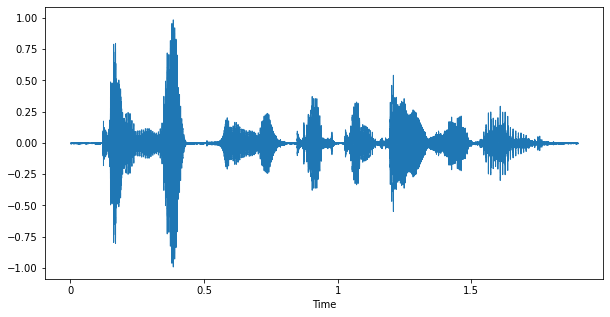

In [5]:
# Let's visualize what we are doing!
# some of this code taken from https://github.com/MiteshPuthran/Speech-Emotion-Analyzer/blob/master/final_results_gender_test.ipynb
import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
librosa.display.waveshow(X, sr=sample_rate)

In [13]:
# putting features into dataframes
import os
from dataset import extract_dataset_features

# needs "/" at end of filepath
data_filepath = "./datasets/berlin-database-of-emotional-speech-emodb/wav/"
features_df = extract_dataset_features(data_filepath, df)
#print(features_df)

10496

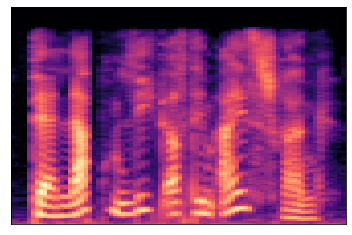

In [18]:
"""
Creating spectrograms from features_df

From this blog post: https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab

"""

def generate_features(y_cut):
    max_size=1000 #my max audio file feature width
    stft = padding(np.abs(librosa.stft(y_cut, n_fft=255, hop_length        = 512)), 128, max_size)
    MFCCs = padding(librosa.feature.mfcc(y_cut, n_fft=n_fft, hop_length=hop_length,n_mfcc=128),128,max_size)
    spec_centroid = librosa.feature.spectral_centroid(y=y_cut, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y_cut, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y_cut, sr=sr)    #Now the padding part
    image = np.array([padding(normalize(spec_bw),1, max_size)]).reshape(1,max_size)
    image = np.append(image,padding(normalize(spec_centroid),1, max_size), axis=0) #repeat the padded spec_bw,spec_centroid and chroma stft until they are stft and MFCC-sized
    for i in range(0,9):
        image = np.append(image,padding(normalize(spec_bw),1, max_size), axis=0)
        image = np.append(image, padding(normalize(spec_centroid),1, max_size), axis=0)
        image = np.append(image, padding(normalize(chroma_stft),12, max_size), axis=0)
    image=np.dstack((image,np.abs(stft)))
    image=np.dstack((image,MFCCs))
    return image



# displaying sample Mel spectrogram
S = librosa.feature.melspectrogram(y=X, sr=sample_rate)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
S.size


In [25]:
"""
This is a different way to create spectrograms and automatically save as a Tensor

Taken from:
https://pytorch.org/audio/stable/generated/torchaudio.transforms.Spectrogram.html

"""

waveform, sample_rate = torchaudio.load("./datasets/berlin-database-of-emotional-speech-emodb/wav/13b03Td.wav", normalize=True)
transform = torchaudio.transforms.Spectrogram(n_fft=800)
spectrogram = transform(waveform)

print(spectrogram.size())

torch.Size([1, 401, 200])


In [7]:
# Now let's shuffle these boiz
from sklearn.model_selection import train_test_split

train, test = train_test_split(features_df, test_size=0.2, random_state=42, shuffle=True)


In [8]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

from torchvision import datasets
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

/home/arthurus-rex/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/arthurus-rex/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/arthurus-rex/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [9]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [10]:
"""
Building Network architecture based on the paper:
Human–Computer Interaction with a Real-Time Speech
Emotion Recognition with Ensembling Techniques 1D
Convolution Neural Network and Attention
(https://doi.org/10.3390/s23031386)

We are taking the output of CNN as the input of LSTM.
CNN captures local patterns in audio features, and
LSTM learns temporal dependencies before making final prediction. This supports
robust sequence prediction.
"""

import torch.nn as nn
import torch.nn.functional as F

class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        # bn = batch normalization
        ####################
        # Convolution blocks: 1dconv, batch norm, ReLU, max pooling
        # Conv block 1
        self.conv1 = nn.Conv1d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm1d(8)

        # Conv block 2
        self.conv2 = nn.Conv1d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm1d(16)

        # Conv block 3
        self.conv3 = nn.Conv1d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)
        self.bn3 = nn.BatchNorm1d(32)

        # Conv block 4
        self.conv4 = nn.Conv1d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)
        self.bn4 = nn.BatchNorm1d(64)

        # Conv block 5
        self.conv5 = nn.Conv1d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1)
        self.bn5 = nn.BatchNorm1d(128)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size = 2, stride = 2)
        ####################

        ####################
        # LSTM + attention block
        self.lstm1 = nn.LSTM(input_size = 128, hidden_size = 64, num_layers = 1, bias = True)

        self.attention = nn.Linear(64, 1)
        self.softmax = nn.Softmax(dim=1)

        self.lstm2 = nn.LSTM(input_size = 64, hidden_size = 64, num_layers = 1, bias = True)
        ####################


        self.fc1 = nn.Linear(64, 32) # May need to increase 32 to capture more complex data (?)
        self.bn6 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, 16)


    def forward(self, x):
        # Conv block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Conv block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)

        # Conv block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)

        # Conv block 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.pool(x)

        # Conv block 5
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)
        x = self.pool(x)

        # LSTM + attention block
        # output_tensor, hiddenstate = self.lstm()
        lstm1_out, _ = self.lstm1(x)

        attention_weights = self.softmax(self.attention(lstm1_out))
        context = torch.sum(attention_weights * lstm1_out, dim=1)

        lstm2_out, _ = self.lstm2(context.unsqueeze(-1))

        # fully connected layers and softmax
        x = self.fc1(lstm2_out.squeeze(1))
        x = self.bn6(x)
        x = self.fc2(x)

        # Softmax for prediction
        # F.softmax is used instead of self.softmax because it is not associated
        # with any parameters
        x = F.softmax(x, dim=1)

        return x

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net =  CNN_LSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer =  optim.Adam(net.parameters(), lr=1e-4)

In [12]:
# Training loop
root_dir = './runs'
os.makedirs(root_dir, exist_ok=True)

def train_on_features(net, optimizer, device, trainloader, critrerion, epochs=1):
    if torch.cuda.is_available():
        net.cuda()
    net.train()

    loss_min = float('inf')
    for epoch in range(epochs):
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            pred = net(inputs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            
            if loss < loss_min:
                torch.save(net.state_dict(), os.path.join(root_dir, "best_ser_model.pth"))


    print('Finished Training')
    return net

net = train_on_features(net, optimizer, device, trainloader, criterion)

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/arthurus-rex/.local/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/arthurus-rex/.local/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/home/arthurus-rex/.local/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 277, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/home/arthurus-rex/.local/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 144, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/home/arthurus-rex/.local/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 144, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/home/arthurus-rex/.local/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 121, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/home/arthurus-rex/.local/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 174, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [36303] at entry 0 and [48582] at entry 1


In [ ]:
#net = train_on_features(net, optimizer, device, trainloader, criterion)
# trainloader = DataLoader(trainset, batch_size=1, shuffle=True, num_workers=1)
# for i, data in enumerate(trainloader):
#     print(data)
print(trainset[0])